In [1]:
using thesis, PRMaps
using Healpix
using Plots
using Plots.PlotMeasures
using Statistics
using Distributions
using LinearAlgebra
using Dates
using JLD2
using LaTeXStrings

import Pandas as Pd
import Stripeline as Sl

# Pointing accuracy

In [2]:
function point_error(error_rad)
    t_start = DateTime(2022, 1, 1, 12, 0, 0)
    obs_days = 5

    setup = PRMaps.Setup(
        sampling_freq_Hz = 50.,
        total_time_s = 24. * 3600. * obs_days
    )
    w2_TA = Sl.TelescopeAngles(wheel2ang_0_rad = error_rad)
    w3_TA = Sl.TelescopeAngles(wheel3ang_0_rad = error_rad)
    fork_TA = Sl.TelescopeAngles(forkang_rad = error_rad)
    wω_TA_0 = Sl.TelescopeAngles(zVAXang_rad = error_rad, ωVAXang_rad = deg2rad(0.0))
    wω_TA_90 = Sl.TelescopeAngles(zVAXang_rad = error_rad, ωVAXang_rad = deg2rad(90.0))
    wω_TA_180 = Sl.TelescopeAngles(zVAXang_rad = error_rad, ωVAXang_rad = deg2rad(180.0))
    wω_TA_270 = Sl.TelescopeAngles(zVAXang_rad = error_rad, ωVAXang_rad = deg2rad(270.0))

    tel_ang = [w2_TA, w3_TA, fork_TA, wω_TA_0, wω_TA_90, wω_TA_180, wω_TA_270]

    pointing_error = []
    for t in tel_ang
        push!(pointing_error, pointing_error_arcmin(Sl.CameraAngles(), t, setup, t_start))
    end

    return pointing_error
end

point_error (generic function with 1 method)

In [3]:
result = load_object("../results/pointing_accuracy/pointing_accuracy.jld2")

7-element Vector{Any}:
 [0.5001277791162275, 1.0002555445057448, 5.001277174400803]
 [0.1710484695344172, 0.3420969406233347, 1.7104845751841167]
 [0.46995181096655897, 0.9399036216475612, 4.6995180625344375]
 [7.06982974289663e-5, 0.00028279318379151476, 0.007069824878585124]
 [7.069830655294372e-5, 0.00028279322017732883, 0.007069825787495927]
 [7.069829739263494e-5, 0.00028279318363947146, 0.0070698248747592994]
 [7.069828913553394e-5, 0.00028279315066424593, 0.007069824050983213]

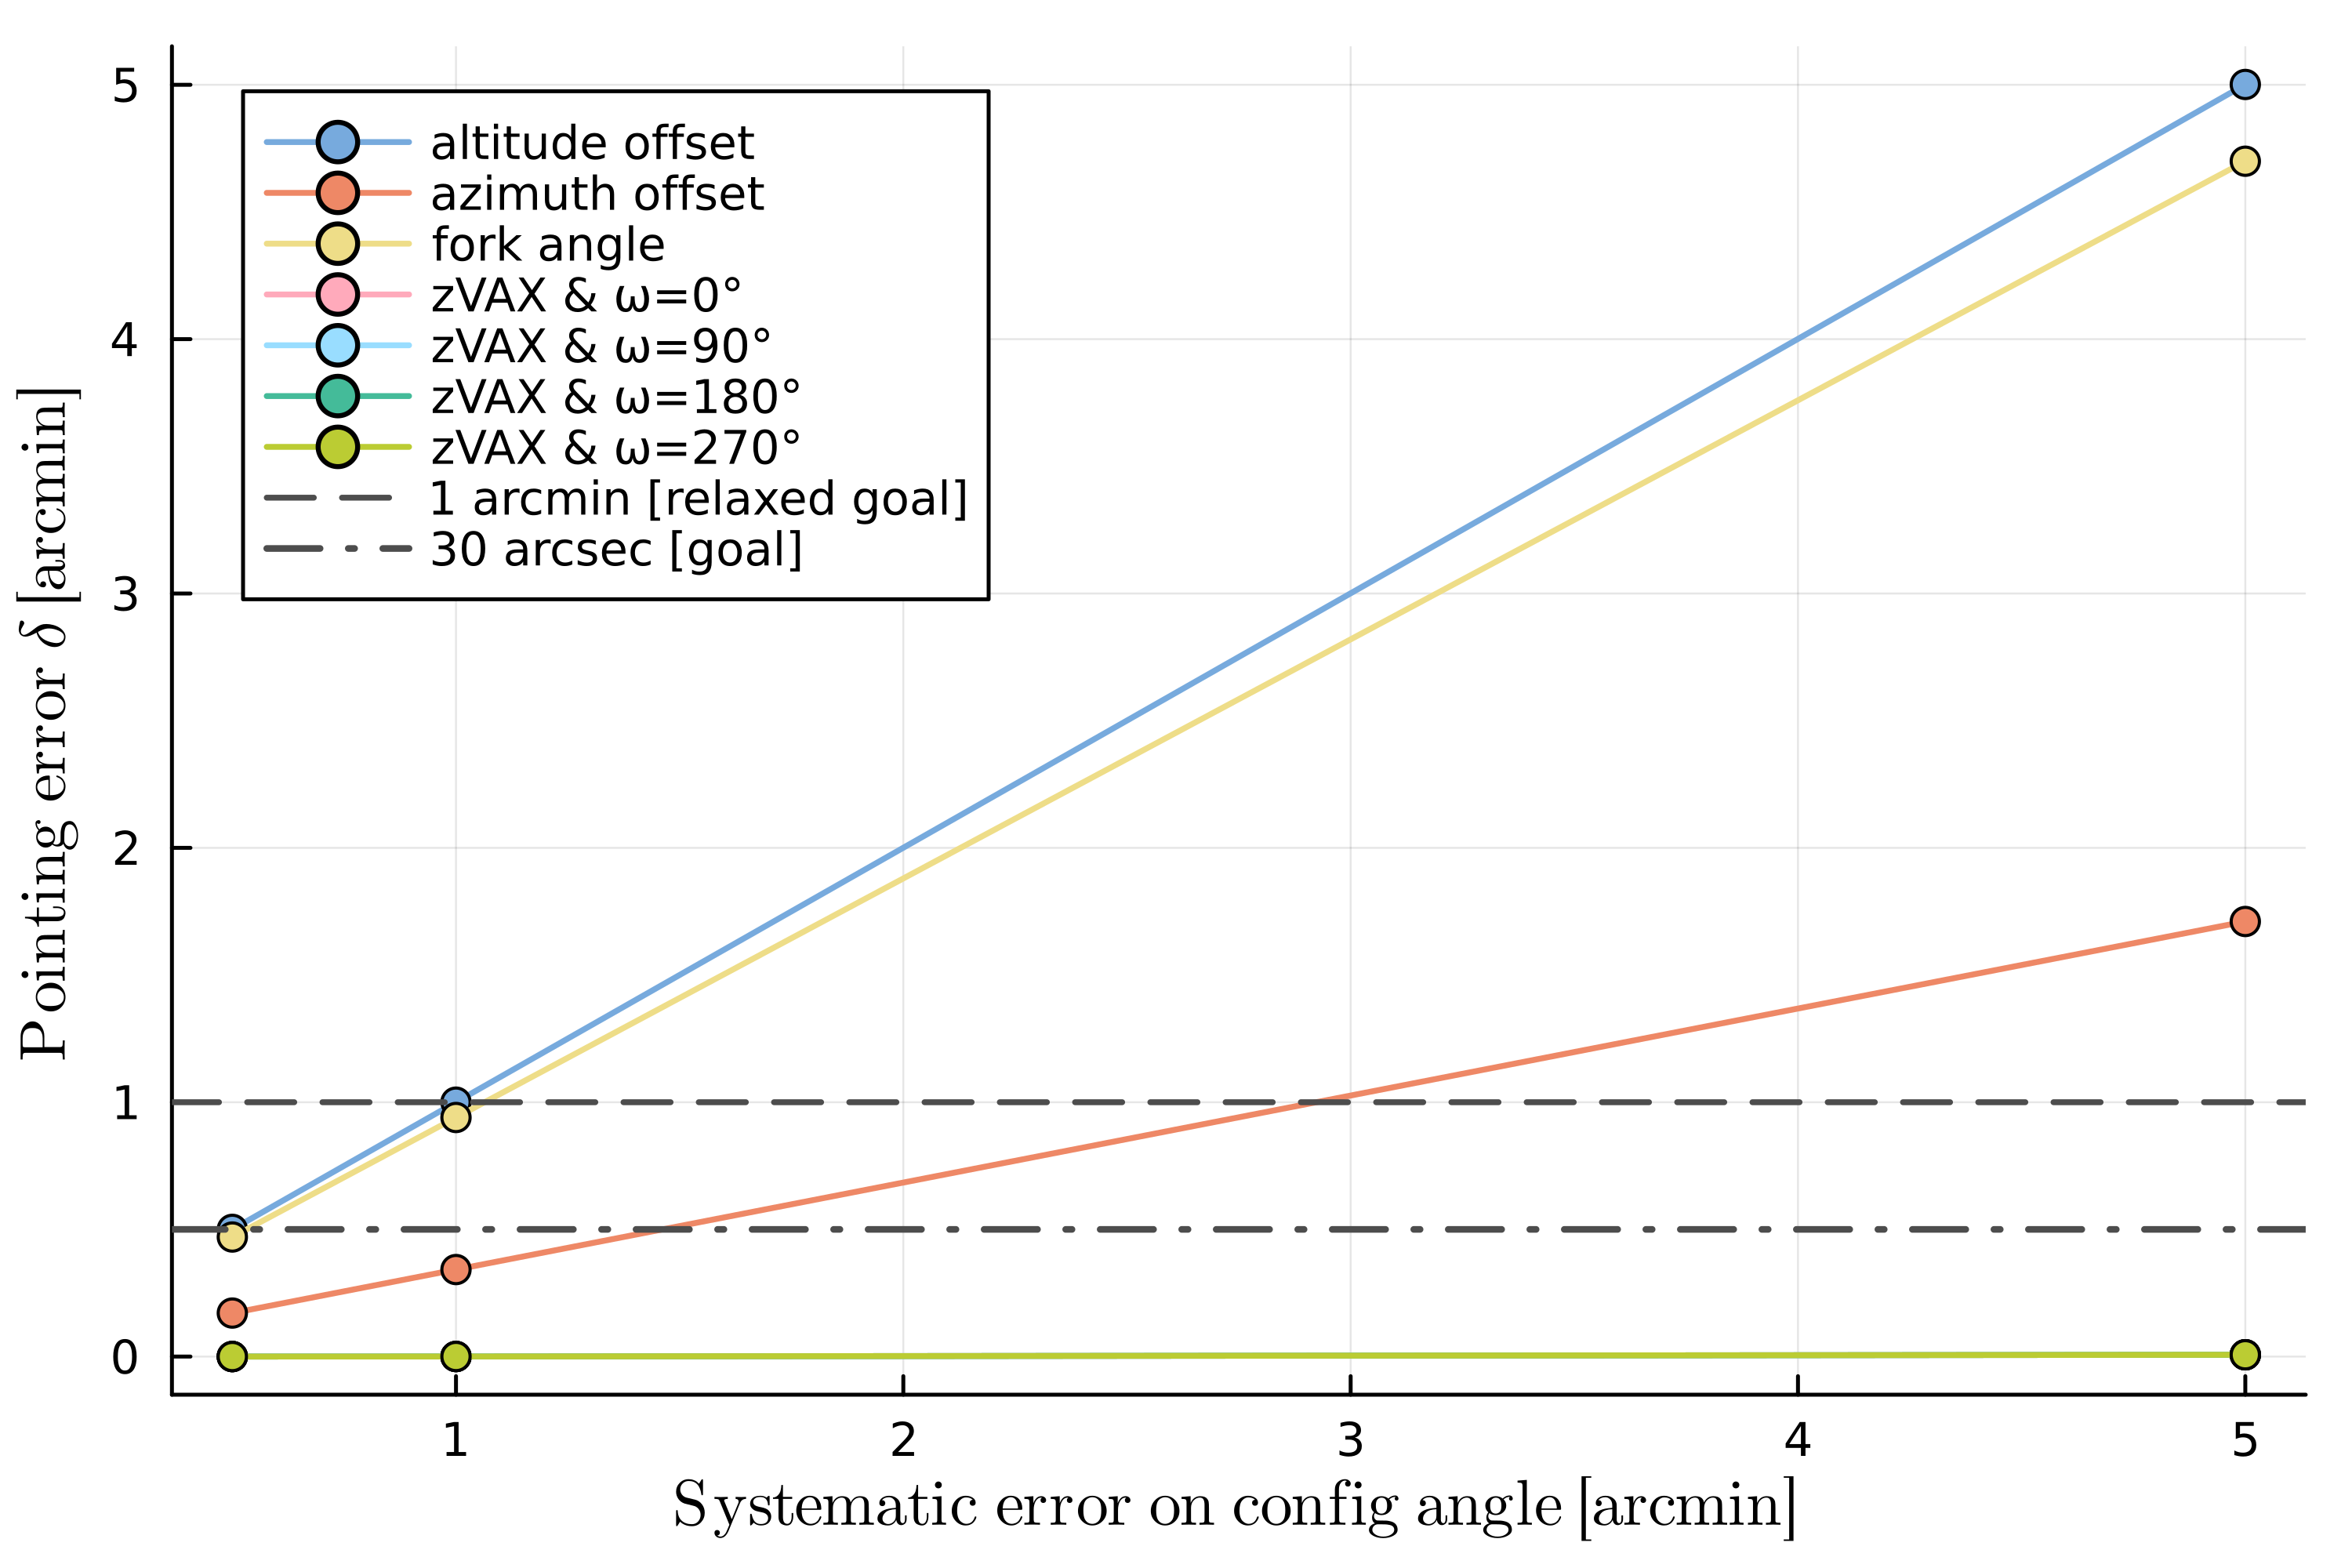

In [4]:
labels = ["altitude offset" "ground offset" "fork angle" "zVAX&ω_0" "zVAX&ω_90" "zVAX&ω_180" "zVAX&ω_270"]
labels = ["altitude offset" "azimuth offset" "fork angle" "zVAX & ω=0°" "zVAX & ω=90°" "zVAX & ω=180°" "zVAX & ω=270°"]
p = plot([0.5, 1, 5], result, labels = labels, linewidth = 1.5, marker = :circle, palette = :tol_light, dpi = 500)
xaxis!(L"\textrm{Systematic \ error \ on \ config \ angle \ [arcmin]}")
yaxis!(L"\textrm{Pointing \ error \ δ \ [arcmin]}")
hline!([1], label = "1 arcmin [relaxed goal]", style=:dash, linewidth = 1.5, color=:gray30)
hline!([0.5], label = "30 arcsec [goal]", style=:dashdot, linewidth = 1.7, color=:gray30)
#hline!([0.25], label = "15 arcsec accuracy", style=:dash)

savefig("../results/pointing_accuracy/accuracy.pdf")
display(p)

# Simulation duration

In [5]:
function duration()
    
    t_start = DateTime(2022, 1, 1, 12, 0, 0)

    tel_ang = Sl.TelescopeAngles(wheel2ang_0_rad = deg2rad(1.0/60))
    
    days = [5, 50, 100, 200, 400, 600]

    setups = [PRMaps.Setup(sampling_freq_Hz = 50., total_time_s = 24. * 3600. * i) for i in days]
    
    result = [pointing_error_arcmin(Sl.CameraAngles(), tel_ang, setup, t_start) for setup in setups]
    
    return result
end

duration (generic function with 1 method)

In [6]:
#duration_vec = duration()
#save_object("duration.jld2", duration_vec)

In [7]:
duration_vec = load_object("../results/simulation_duration/pointing_accuracy/duration.jld2")

6-element Vector{Float64}:
 1.0002555445057448
 1.0002495389000228
 1.000246089267341
 1.00025021247346
 1.0002590250468695
 1.0002572742497442

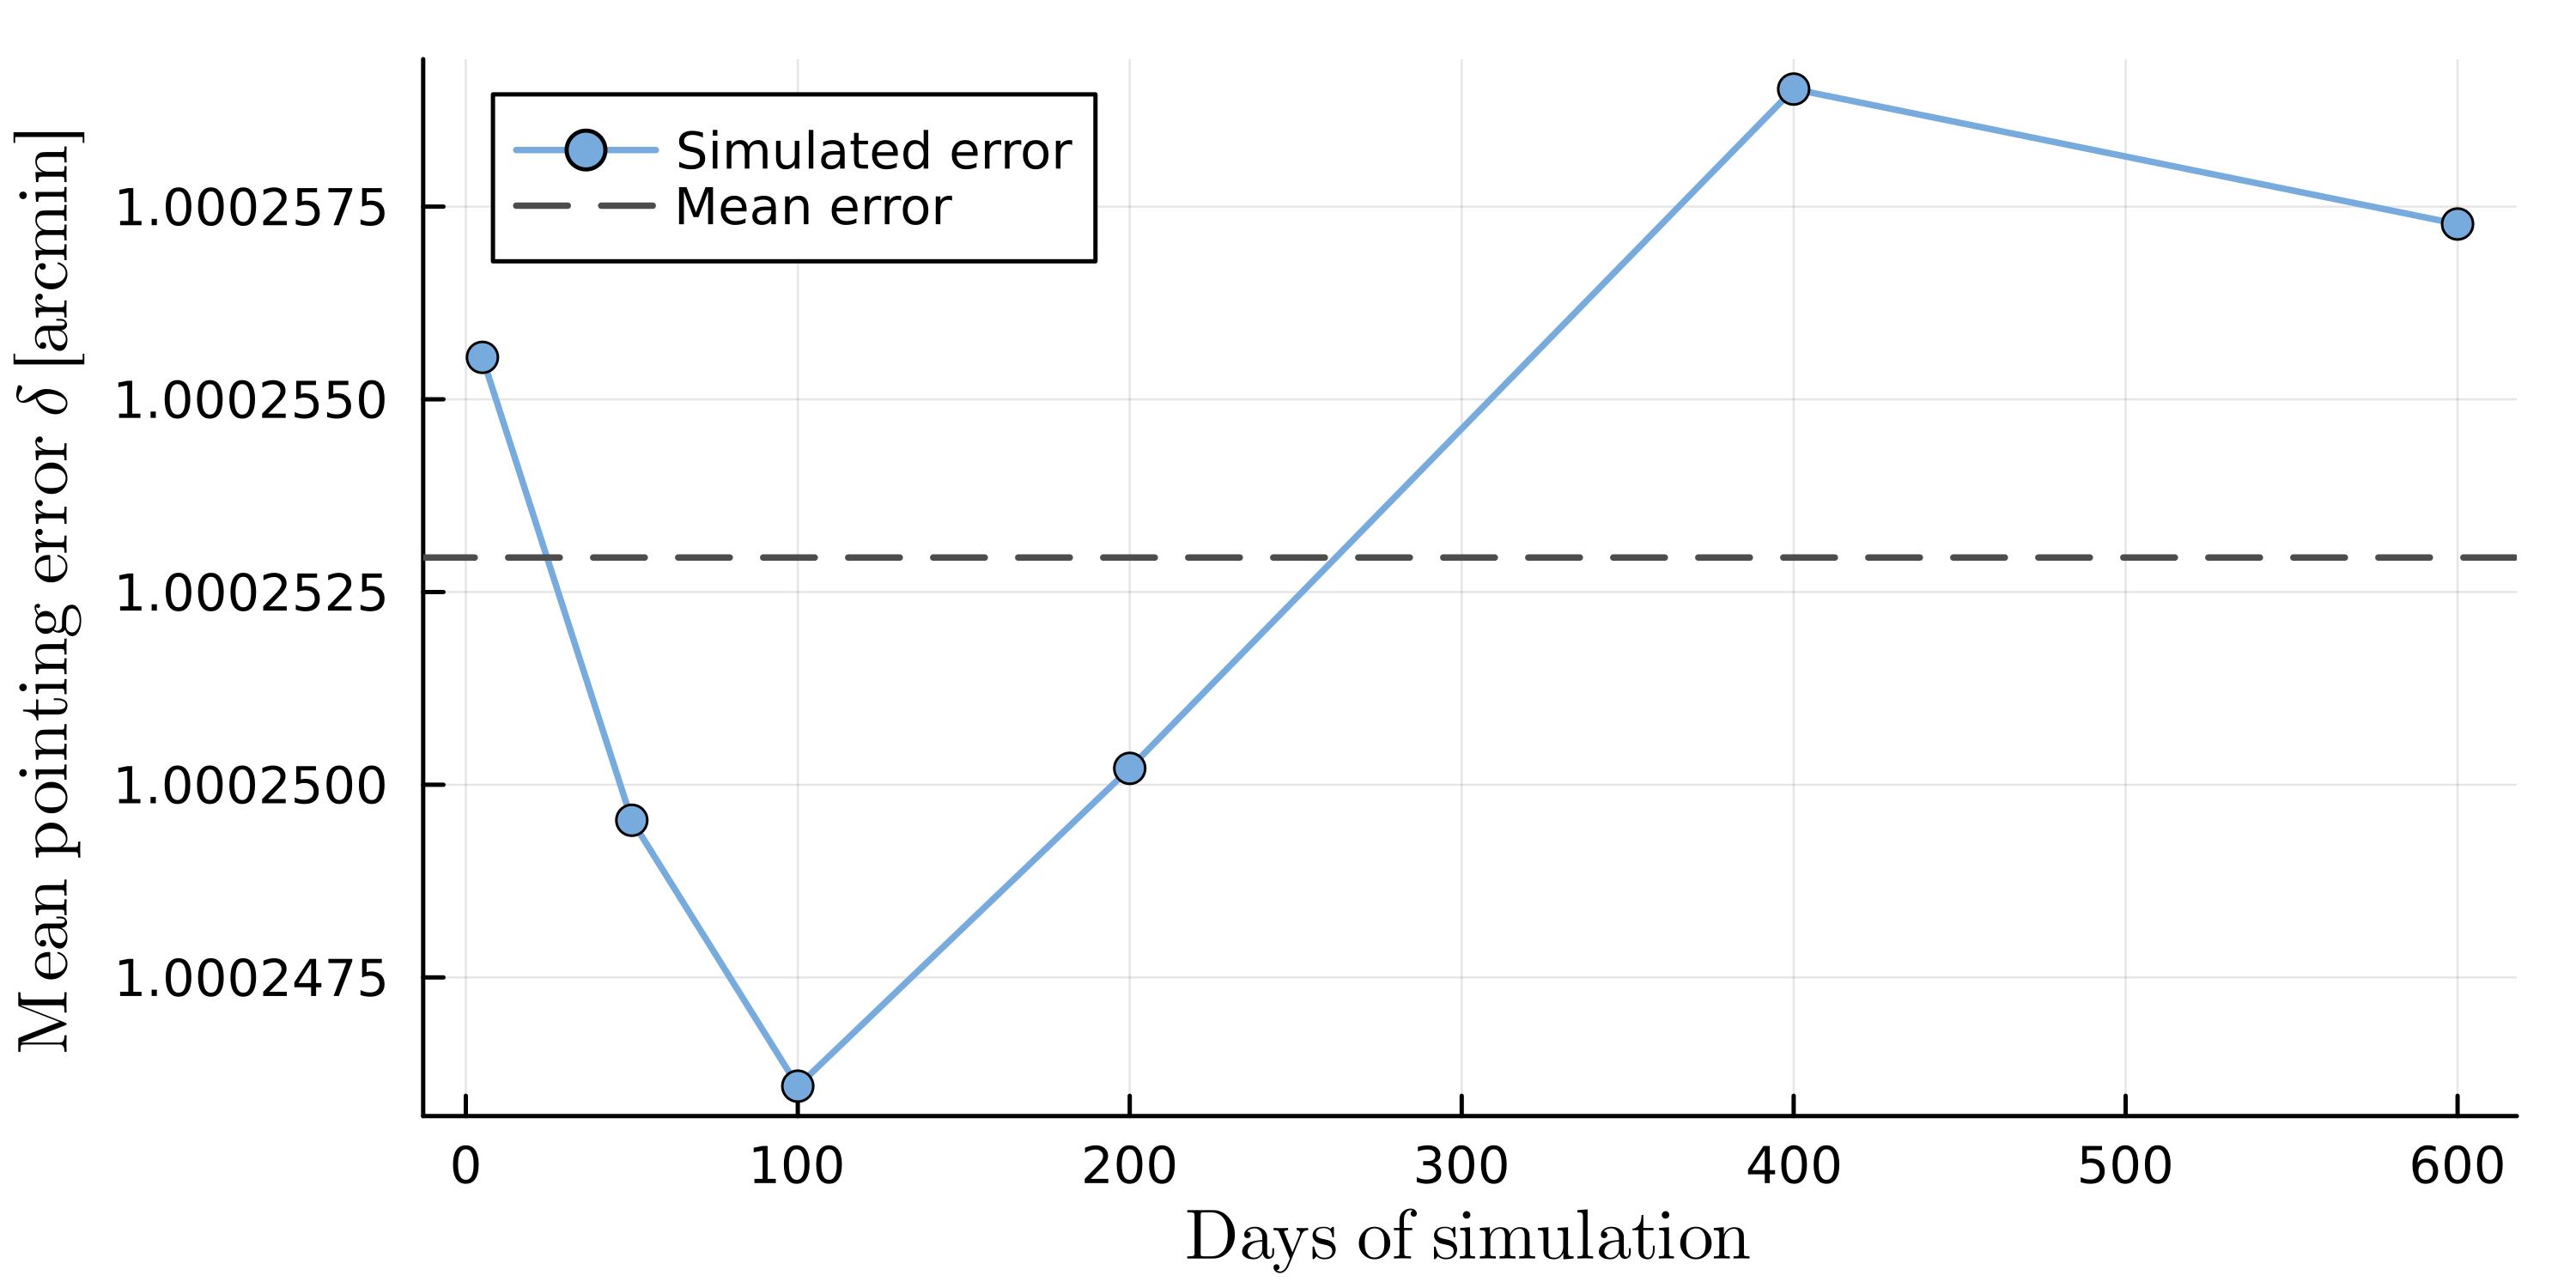

In [8]:
a = plot([5, 50, 100, 200, 400, 600], duration_vec, marker = :circle, linewidth=1.5, label = "Simulated error", size = (600, 300), 
    dpi = 500, 
    palette = :tol_light, 
    margin = 1.5mm,
    formatter = :plain
    )
hline!([mean(duration_vec)], linewidth=1.5, style=:dash, color=:gray30, label = "Mean error")
xaxis!(L"\textrm{Days \ of \ simulation}")
yaxis!(L"\textrm{Mean \ pointing \ error \ δ \ [arcmin]}")

savefig("../results/simulation_duration/pointing_accuracy/duration.pdf")
display(a)

# Total polarization

In [9]:
labels = ["altitude_offset" "ground_offset" "fork" "zVAX&ω_0" "zVAX&ω_90" "zVAX&ω_180" "zVAX&ω_270"]
maps = PolarizedHealpixMap[]
for name in labels
    push!(maps, readPolarizedMapFromFITS(joinpath("maps_10days_s0/maps",name*".fits"), 1, Float64))
end
ideal = readPolarizedMapFromFITS(joinpath("maps_10days_s0/maps","ideal.fits"), 1, Float64)
nothing

In [10]:
maps_pol = HealpixMap[]
for map in maps
    buffer = HealpixMap{Float64, RingOrder}(map.i.resolution.nside)
    polDegreeMap!(buffer, map.q, map.u)
    
    push!(maps_pol, buffer)
end

ideal_pol = HealpixMap{Float64, RingOrder}(ideal.i.resolution.nside)
polDegreeMap!(ideal_pol, ideal.q, ideal.u)

nothing

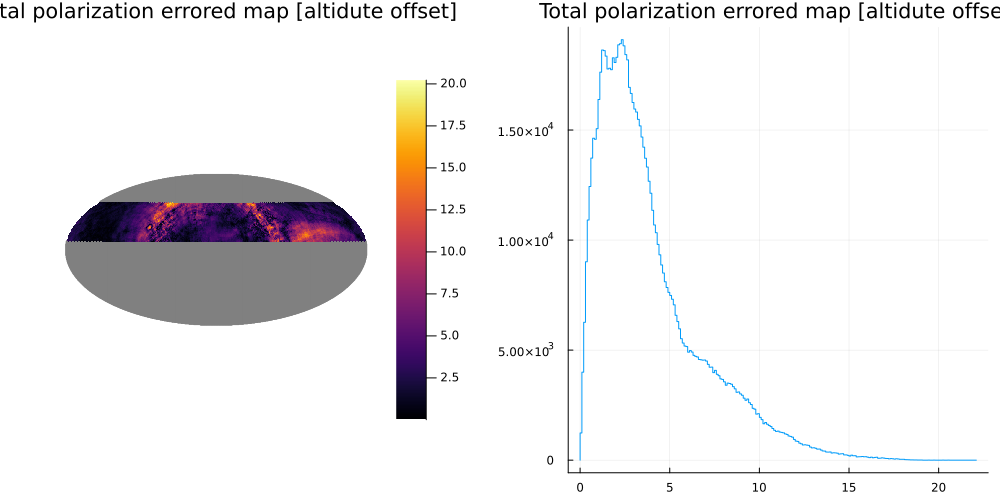

In [11]:
a = plot(maps_pol[1])
b = stephist(maps_pol[1][isfinite.(maps_pol[1])], legend = false)
plot(a,b, size = (1000, 500), title = "Total polarization errored map [altidute offset]")

# Total polarization error

In [12]:
error_pol = HealpixMap[]
for map in maps_pol
    push!(error_pol, ideal_pol-map)
end

nothing

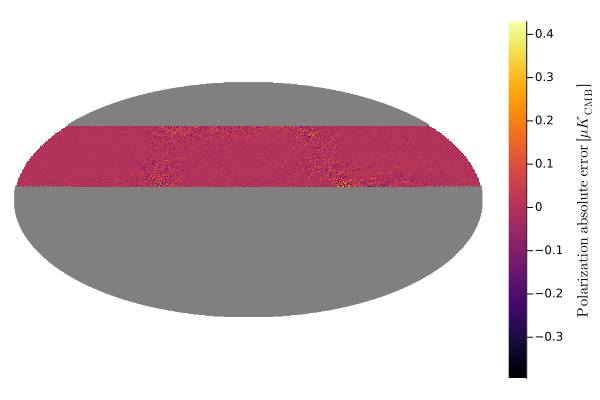

In [13]:
m = plot(error_pol[1], colorbar_title=" \n"*L"\textrm{Polarization \ absolute \ error} \ [\mu K_\textrm{CMB}]", dpi=100, 
    leftmargin = -20mm, 
    right_margin = 5mm,
    bottom_margin = -30mm,
    top_margin = -30mm
    )
savefig("../results/10days_s0/pol_error_altitude.png")
display(m)

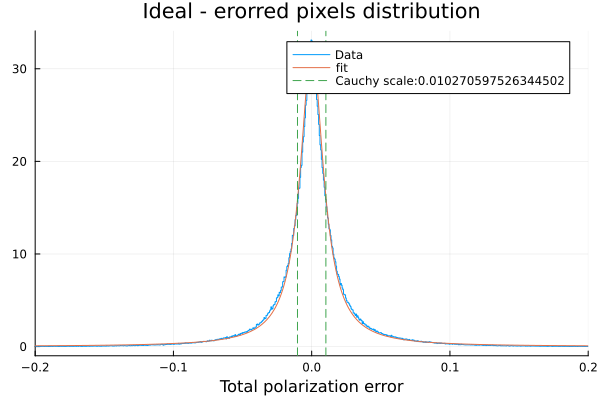

In [14]:
error_type = 1
xlim = 000.2

data = error_pol[error_type][isfinite.(error_pol[error_type])]
#data = abs.(data)

stephist(data, normalize = true, label="Data", xlim=(-xlim,xlim))

distro_fit = fit(Cauchy, data)
#distro_plot = truncated(distro_fit, minimum(data), maximum(data))
distro_plot = truncated(distro_fit, -xlim, xlim)

plot!(distro_plot, normalize = true, label = "fit", xlabel="Total polarization error" , xlim=(-xlim,xlim))
#vline!([-std(data), std(data)], label = "Std:"*string(std(data))[1:5], style=:dash)
vline!([-scale(distro_fit),scale(distro_fit)], label = "Cauchy scale:"*string(scale(distro_fit)), style=:dash)
title!("Ideal - erorred pixels distribution")
#savefig("../results/error_nature/pol_degree.pdf")

In [15]:
μ = []
σ = []

for (indx, config) in enumerate(labels)
    data = error_pol[indx][isfinite.(error_pol[error_type])]
    distro_fit = fit(Cauchy, data)
    push!(μ, location(distro_fit))
    push!(σ, scale(distro_fit))
end

μ

7-element Vector{Any}:
  9.809318452486115e-5
  3.696520099794043e-6
  0.00015188156516787732
  1.875427391162532e-8
  1.6892441001559177e-8
 -2.4610828319726608e-8
 -1.569212704222167e-8

# Total polarization histograms

In [16]:
labels = ["altitude offset" "azimuth offset" "fork angle" "zVAX & ω=0°" "zVAX & ω=90°" "zVAX & ω=180°" "zVAX & ω=270°"]
error_pol_hist = []
for map in error_pol
    push!(error_pol_hist, map[isfinite.(map)])
end

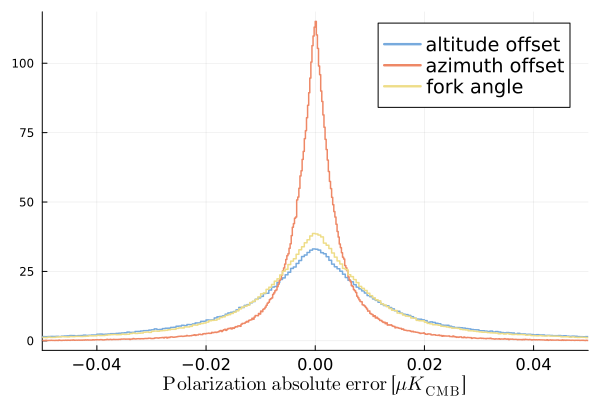

In [17]:
xlim = 0.05
a = stephist(error_pol_hist[1], bins = 3000, label = labels[1], xlim=(-xlim,xlim), normalize = :pdf, linewidth = 1.5, palette = :tol_light, 
    xtickfontsize=11,
    ytickfontsize=8, 
    xguidefontsize=13,
    legendfontsize = 13,
    )
a = stephist!(error_pol_hist[2], bins = 3000, label = labels[2], xlim=(-xlim,xlim), normalize = :pdf, linewidth = 1.5, palette = :tol_light)
a = stephist!(error_pol_hist[3], bins = 3000, label = labels[3], xlim=(-xlim,xlim), normalize = :pdf, linewidth = 1.5, palette = :tol_light)
a = xaxis!(L"\textrm{Polarization \ absolute \ error} \ [\mu K_\textrm{CMB}]")
savefig("../results/10days_s0/histogram_1.pdf")
display(a)

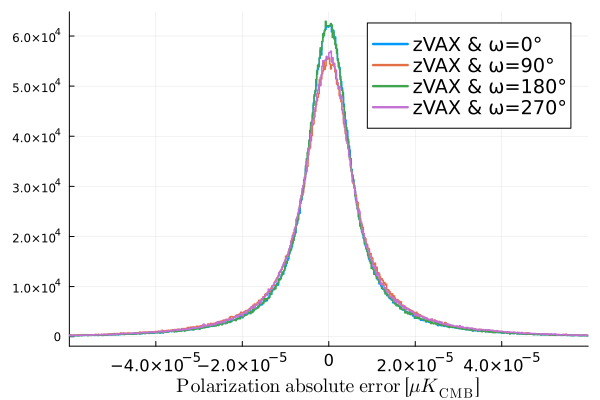

In [18]:
xlim = 0.00006
b = stephist(error_pol_hist[4], bins = 3000, label = labels[4], xlim=(-xlim,xlim), normalize = :pdf, linewidth = 1.5, 
    xtickfontsize=11, 
    ytickfontsize=8, 
    xguidefontsize=13,
    legendfontsize = 13
    )
b = stephist!(error_pol_hist[5], bins = 3000, label = labels[5], xlim=(-xlim,xlim), normalize = :pdf, linewidth = 1.5)
b = stephist!(error_pol_hist[6], bins = 3000, label = labels[6], xlim=(-xlim,xlim), normalize = :pdf, linewidth = 1.5)
b = stephist!(error_pol_hist[7], bins = 3000, label = labels[7], xlim=(-xlim,xlim), normalize = :pdf, linewidth = 1.5)
b = xaxis!(L"\textrm{Polarization \ absolute \ error} \ [\mu K_\textrm{CMB}]")
#title!("Pixel distribution of the error map")
savefig("../results/10days_s0/histogram_2.pdf")
display(b)